In [1]:
import tensorflow as tf
import pandas as pd
import keras
import numpy as np


In [2]:
df = pd.read_csv('data/train.csv')
print(df.shape)

(891, 12)


In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Change data type for object type columns to string
def fix_type(df):
    df[['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']] = df[['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']].astype(str) 
    return df




In [5]:
#Apply function for changing data type to string
df = fix_type(pd.read_csv('data/train.csv'))
# val_df = fix_type(pd.read_csv('data/test.csv'))

#Make nan avg in Age column.
print(df.isnull().sum())

df['Age'].fillna((df['Age'].mean()), inplace=True)

print(df.isnull().sum())


df['SibSp'] = df['SibSp'].astype('float32')
df['Parch'] = df['Parch'].astype('float32')
df = df.drop(columns=['PassengerId'])
val_dataframe = df.sample(frac=0.2, random_state=1337)
train_dataframe = df.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
dtype: int64
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64
Using 713 samples for training and 178 for validation


In [7]:
#generate dataset objects
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("Survived")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [8]:
#x input is a dictionary and y is value of 0 or 1
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'Pclass': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'Name': <tf.Tensor: shape=(), dtype=string, numpy=b'Wells, Miss. Joan'>, 'Sex': <tf.Tensor: shape=(), dtype=string, numpy=b'female'>, 'Age': <tf.Tensor: shape=(), dtype=float64, numpy=4.0>, 'SibSp': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, 'Parch': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, 'Ticket': <tf.Tensor: shape=(), dtype=string, numpy=b'29103'>, 'Fare': <tf.Tensor: shape=(), dtype=float64, numpy=23.0>, 'Cabin': <tf.Tensor: shape=(), dtype=string, numpy=b'nan'>, 'Embarked': <tf.Tensor: shape=(), dtype=string, numpy=b'S'>}
Target: tf.Tensor(1, shape=(), dtype=int64)


In [9]:
#batches
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [10]:
df.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp       float32
Parch       float32
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [11]:
from keras.utils import FeatureSpace

#pass to a dictionary that maps the name of our features to a string that describes the feature type.

feature_space = FeatureSpace(
    features={
        #'PassengerId': 'float',
        'Pclass': 'integer_categorical',
        'Name': 'string_hashed',
        'Sex': 'string_categorical',
        'Age': 'float',
        'SibSp': 'float',
        'Parch': 'float',
        'Ticket': 'string_hashed',
        'Fare': 'float_normalized',
        'Cabin': 'string_hashed',
        'Embarked': 'string_categorical',
    },
    # We create additional features by hashing
    # value co-occurrences for the
    # following groups of categorical features.
    crosses=[('Sex', 'Pclass')],
    # # The hashing space for these co-occurrences
    # # wil be 32-dimensional.
    crossing_dim=32,
    # Our utility will one-hot encode all categorical
    # features and concat all features into a single
    # vector (one vector per sample).
    output_mode="concat",
)

In [12]:
#adapt featurespace to training model
train_ds_with_no_labels = train_ds.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

In [13]:
for x, _ in train_ds.take(1):
    print(x)
    
    preprocessed_x = feature_space(x)
    print("preprocessed_x.shape:", preprocessed_x.shape)
    print("preprocessed_x.dtype:", preprocessed_x.dtype)

{'Pclass': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([1, 3, 3, 3, 3, 1, 3, 2, 2, 3, 2, 2, 1, 1, 2, 3, 1, 3, 1, 1, 3, 2,
       3, 2, 3, 3, 3, 3, 3, 1, 1, 3])>, 'Name': <tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'Gee, Mr. Arthur H', b'Morrow, Mr. Thomas Rowan',
       b'Markun, Mr. Johann', b'Moor, Mrs. (Beila)', b'Coleff, Mr. Peju',
       b'Ostby, Mr. Engelhart Cornelius',
       b'de Messemaeker, Mrs. Guillaume Joseph (Emma)',
       b'Hold, Mr. Stephen', b'Hood, Mr. Ambrose Jr',
       b'Keefe, Mr. Arthur', b'Wilhelms, Mr. Charles',
       b'Cunningham, Mr. Alfred Fleming', b'Dodge, Master. Washington',
       b'Bazzani, Miss. Albina', b'Doling, Miss. Elsie',
       b'Asplund, Miss. Lillian Gertrud', b'Ross, Mr. John Hugo',
       b'Stankovic, Mr. Ivan', b'Barber, Miss. Ellen "Nellie"',
       b'Bradley, Mr. George ("George Arthur Brayton")',
       b'Davies, Mr. Alfred J', b'Turpin, Mr. William John Robert',
       b'Albimona, Mr. Nassef Cassem',
       b'Leyson

In [14]:
#training validation of preprocessed batches
preprocessed_train_ds = train_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_train_ds = preprocessed_train_ds.prefetch(tf.data.AUTOTUNE)

preprocessed_val_ds = val_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_val_ds = preprocessed_val_ds.prefetch(tf.data.AUTOTUNE)


In [15]:
#build model
dict_inputs = feature_space.get_inputs()
encoded_features = feature_space.get_encoded_features()

x = keras.layers.Dense(64, activation="relu")(encoded_features)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(1, activation="sigmoid")(x)

training_model = keras.Model(inputs=dict_inputs, outputs=predictions)
training_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

# inference_model = keras.Model(inputs=dict_inputs, outputs=predictions)

In [16]:
#train model
train_x = train_dataframe.copy()
train_y = train_x.pop('Survived')


training_model.fit(
    dict(train_x),train_y, epochs=50, verbose=1
)

# training_model.fit(
#     preprocessed_train_ds, epochs=50, validation_data=preprocessed_val_ds, verbose=2
# )

Epoch 1/50
23/23 [==============================] - 0s 1ms/step - loss: 1.4292 - accuracy: 0.5470
Epoch 2/50
23/23 [==============================] - 0s 1ms/step - loss: 1.2056 - accuracy: 0.5820
Epoch 3/50
23/23 [==============================] - 0s 1ms/step - loss: 1.1158 - accuracy: 0.5891
Epoch 4/50
23/23 [==============================] - 0s 1ms/step - loss: 0.9875 - accuracy: 0.6269
Epoch 5/50
23/23 [==============================] - 0s 1ms/step - loss: 0.8395 - accuracy: 0.6564
Epoch 6/50
23/23 [==============================] - 0s 1ms/step - loss: 0.7113 - accuracy: 0.6858
Epoch 7/50
23/23 [==============================] - 0s 1ms/step - loss: 0.6842 - accuracy: 0.7097
Epoch 8/50
23/23 [==============================] - 0s 1ms/step - loss: 0.6418 - accuracy: 0.7349
Epoch 9/50
23/23 [==============================] - 0s 1ms/step - loss: 0.5993 - accuracy: 0.7349
Epoch 10/50
23/23 [==============================] - 0s 1ms/step - loss: 0.5528 - accuracy: 0.7447
Epoch 11/50
23/23 [

In [17]:
training_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Pclass (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 Sex (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 Cabin (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 Embarked (InputLayer)          [(None, 1)]          0           []                               
                                                                                              

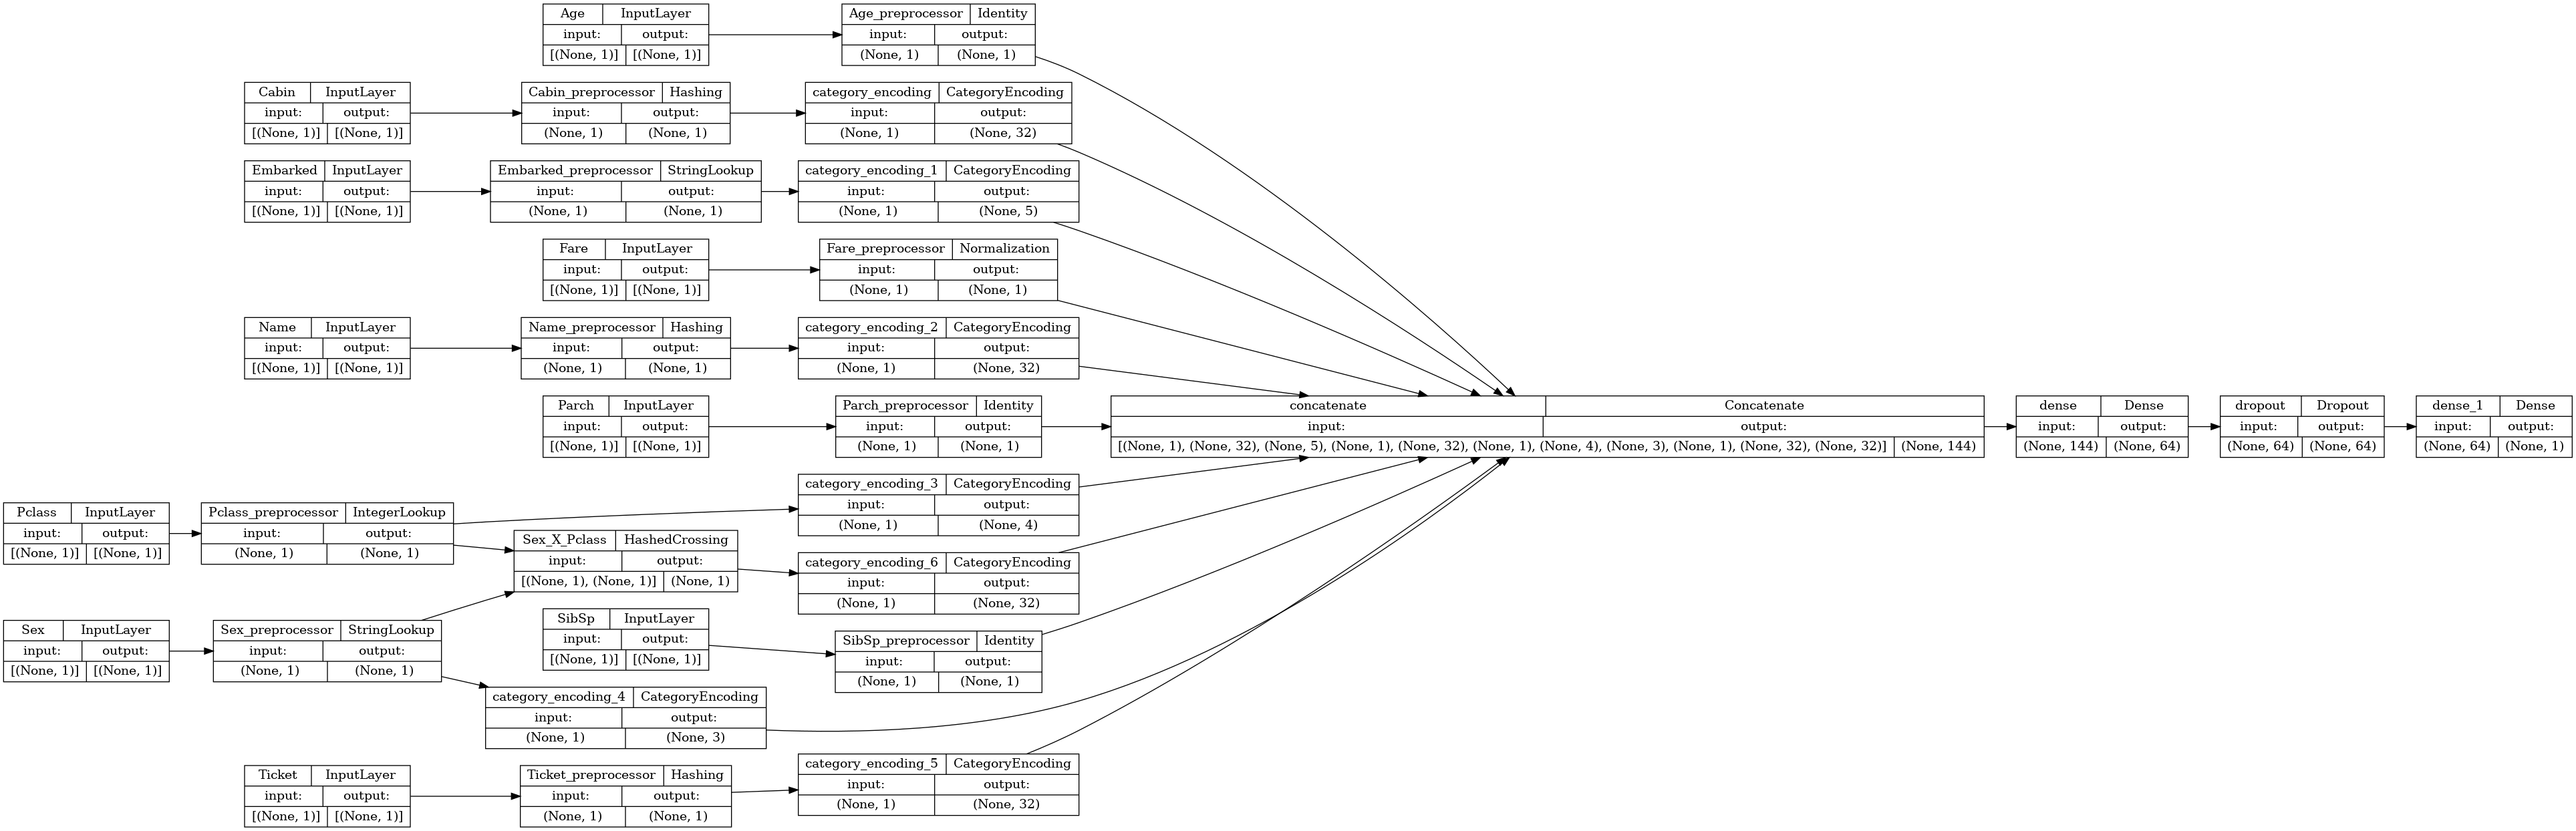

In [18]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(training_model, show_shapes=True, rankdir="LR")

In [19]:
#save model
training_model.save('titanic_model_v1.keras')

NotImplementedError: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer StringLookup with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0xffff43544130>]

![model](model.png)


![Netron](titanic_model_v1.keras.svg)


![detailed](titanic_model_v1_detailed.keras.svg)